# ReGraph tutorial: from simple graph rewriting to a graph hierarchy

This notebook consists of simple examples of usage of the ReGraph library

In [1]:
import copy

import networkx as nx

from regraph.library.hierarchy import Hierarchy
from regraph.library.rules import Rule
from regraph.library.plotting import plot_graph, plot_instance, plot_rule
from regraph.library.primitives import find_matching, rewrite, print_graph
from regraph.library.utils import keys_by_value

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## I. Simple graph rewriting

### 1. Initialization of a graph

ReGraph works with NetworkX graph objects, both undirected graphs (`nx.Graph`) and directed ones (`nx.DiGraph`). The workflow of the graph initialization in NetworkX can be found [here](http://networkx.readthedocs.io/en/networkx-1.11/tutorial/tutorial.html).

In [3]:
graph = nx.DiGraph()
graph.add_nodes_from([
    ('1', {'name': 'EGFR', 'state': 'p'}),
    ('2', {'name': 'BND'}),
    ('3', {'name': 'Grb2', 'aa': 'S', 'loc': 90}),
    ('4', {'name': 'SH2'}),
    ('5', {'name': 'EGFR'}),
    ('6', {'name': 'BND'}),
    ('7', {'name': 'Grb2'}),
    ('8', {'name': 'WAF1'}),
    ('9', {'name': 'BND'}),
    ('10', {'name': 'G1-S/CDK', 'state': 'p'}),
])
edges = [
    ('1', '2', {'s': 'p'}),
    ('4', '2', {'s': 'u'}),
    ('4', '3'),
    ('5', '6', {'s': 'p'}),
    ('7', '6', {'s': 'u'}),
    ('8', '9'),
    ('9', '8'),
    ('10', '8', {"a": {1}}),
    ('10', '9', {"a": {2}}),
    ('5', '2', {'s': 'u'})
]

graph.add_edges_from(edges)

ReGraph provides some utils for graph plotting that are going to be used in the course of this tutorial.

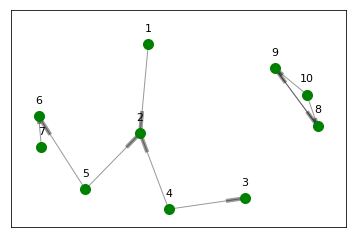

In [4]:
positioning = plot_graph(graph)

### 2. Initialization of a rule

- Graph rewriting is implemented as an application of a **graph rewriting rule** to a given input graph object $G$. A graph rewriting rule $R$  is a span $LHS \leftarrow P \rightarrow RHS$, where $LHS$ is a graph that represents a left hand side of the rule -- a pattern that is going to be matched inside of the graph, $P$ is a graph that represents a preserved part of the rule -- together with a homomorphism $LHS \leftarrow P$ it specifies nodes and edges that are going to be preserved in the course of application of the rule. $RHS$ and a homomorphism $P \rightarrow RHS$ on the other hand specify nodes and edges that are going to be added. In addition, if two nodes $n^P_1, n^P_2$ of $P$ map to the same node $n^{LHS}$ in $LHS$, $n^{LHS}$ is going to be cloned during graph rewriting. Symmetrically, if two nodes of $n^P_1$ and $n^P_2$ in $P$ match to the same node $n^{RHS}$ in $RHS$, $n^P_1$ and $n^P_2$ are merged.

- $LHS$, $P$ and $RHS$ can be defined as NetworkX graphs

In [5]:
pattern = nx.DiGraph()
pattern.add_nodes_from(
    [(1, {'state': 'p'}),
     (2, {'name': 'BND'}),
     3,
     4]
)
pattern.add_edges_from(
    [(1, 2, {'s': 'p'}),
     (3, 2, {'s': 'u'}),
     (3, 4)]
)

p = nx.DiGraph()
p.add_nodes_from([
    (1, {'state': 'p'}),
    '1_clone',
    (2, {'name': 'BND'}),
    3,
    4
])
p.add_edges_from([
    (1, 2),
    ('1_clone', 2),
    (3, 4)
])

rhs = nx.DiGraph()
rhs.add_nodes_from([
    (1, {'state': 'p'}),
    '1_clone',
    (2, {'name': 'BND'}),
    3,
    4,
    5
])

rhs.add_edges_from([
    (1, 2, {'s': 'u'}),
    ('1_clone', 2),
    (2, 4),
    (3, 4),
    (5, 3)
])

p_lhs = {1: 1, '1_clone': 1, 2: 2, 3: 3, 4: 4}
p_rhs = {1: 1, '1_clone': '1_clone', 2: 2, 3: 3, 4: 4}

- A rule of graph rewriting is implemeted in the class `regraph.library.rules.Rule`. An instance of `regraph.library.rules.Rule` is initialized with NetworkX graphs $LHS$, $P$, $RHS$, and two dictionaries specifying $LHS \leftarrow P$ and $P \rightarrow RHS$.
- For visualization of a rule `regraph.library.plotting.plot_rule` util is implemented in ReGraph.

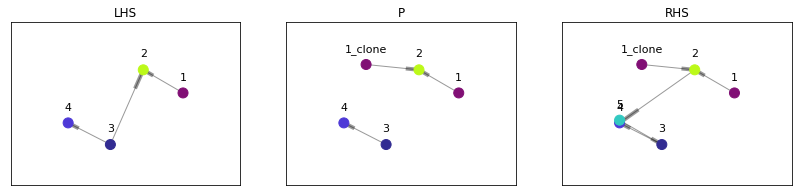

In [6]:
rule = Rule(p, pattern, rhs, p_lhs, p_rhs)
plot_rule(rule)

### 1. Rewriting

#### 1.1. Matching of LHS

- The matchings of $LHS$ in $G$ ($LHS \rightarrowtail G$) can be found using `regraph.library.primitives.find_matching` function. This function returns a list of dictionaries representing the matchings. If no matchings were found the list is empty.
- Visualization of the matching in $G$ is implemented in the `regraph.library.plotting.plot_instance` util.

Instances:
{1: '1', 2: '2', 3: '5', 4: '6'}


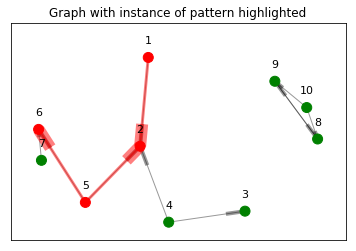

{1: '1', 2: '2', 3: '4', 4: '3'}


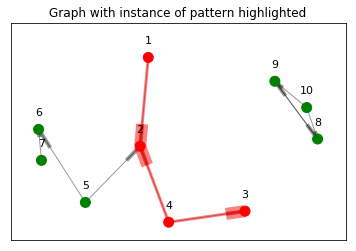

In [7]:
instances = find_matching(graph, rule.lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(graph, rule.lhs, instance, pos=positioning)

#### 1.2. Rewriting

Graph rewriting is performed with the `regraph.library.primitives.rewrite` function. It takes as an input a graph, an instance of the matching (dictionary that specifies the mapping from the nodes of $LHS$ to the nodes of $G$) and a rewriting rule (an instance of the `regraph.library.rules.Rule` class).

In [8]:
rewrite(graph, instances[0], rule)

{1: '1', 2: '2', 3: '5', 4: '6', 5: 5, '1_clone': '11'}

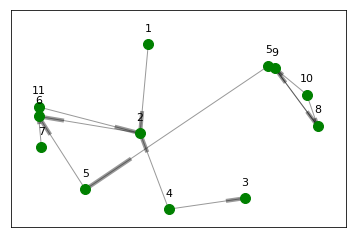

In [9]:
new_pos = plot_graph(graph, parent_pos=positioning)

## II. Hierarchy of graphs & rewriting

ReGraph allows to create a herarchy of graphs connected together by means of **typing homomorphisms**. In the context of hierarchy if there exists a homomorphism $G \rightarrow T$ we say that graph $G$ is typed by a graph $T$. Graph hierarchy is a DAG, where nodes are graphs and edges are typing homomorphisms between graphs.

ReGraph provides two kinds of typing for graphs: **partial typing** and **total typing**.
- **Total typing** ($G \rightarrow T)$ is a homomorphism which maps every node of $G$ to some node in $T$ (a type);
- **Partial typing** ($G \rightharpoonup T$) is a slight generalisation of total typing, which allows only a subset of nodes from $G$ to be typed by nodes in $T$ (to have types in $T$), whereas the rest of the nodes which do not have a mapping to $T$ are considered as nodes which do not have type in $T$.

**Note:** Use total typing if you would like to make sure that the nodes of your graphs are always strictly typed by some metamodel.   

### 1. Example: simple hierarchy 

#### 1.1. Initialization of a hierarchy
Consider the following example of a simple graph hierarchy. The two graphs $G$ and $T$ are being created and added to the heirarchy. Afterwards a typing homomorphism (total) between $G$ and $T$ is added, so that every node of $G$ is typed by some node in $T$.

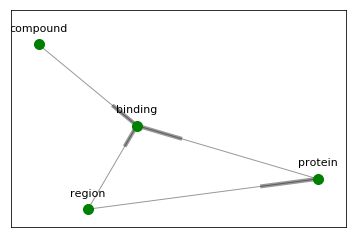

{'binding': array([ 0.22519362,  0.50766542]),
 'compound': array([ 0.,  1.]),
 'protein': array([ 0.63945084,  0.18403018]),
 'region': array([ 0.11333597,  0.        ])}

In [10]:
g = nx.DiGraph()
g.add_nodes_from(["protein", "binding", "region", "compound"])
g.add_edges_from([("region", "protein"), ("protein", "binding"), ("region", "binding"), ("compound", "binding")])
plot_graph(g)

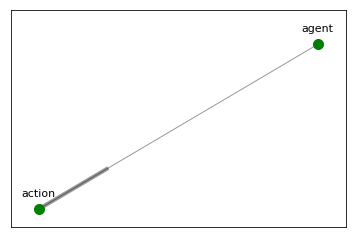

{'action': array([ 0.,  0.]), 'agent': array([ 0.31152889,  1.        ])}

In [11]:
t = nx.DiGraph()
t.add_nodes_from(["action", "agent"])
t.add_edges_from([("agent", "agent"), ("agent", "action")])
plot_graph(t)

In [12]:
simple_hierarchy = Hierarchy()
simple_hierarchy.add_graph("G", g, {"name": "Simple protein interaction"})
simple_hierarchy.add_graph("T", t, {"name": "Agent interaction"})
simple_hierarchy.add_typing(
    "G", "T",
    {"protein": "agent",
     "region": "agent",
     "compound": "agent",
     "binding": "action",
    },
    total=True
)

In [13]:
print(simple_hierarchy)


Graphs (directed == True): 

Nodes:
Graph: G {'name': 'Simple protein interaction'}
Graph: T {'name': 'Agent interaction'}

Typing homomorphisms: 
G -> T: total == True, ignore_attrs == False

attributes : 
{}



We can now add new level to the hierarchy and type in by $G$.

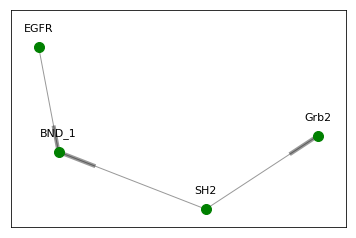

In [14]:
g_prime = nx.DiGraph()
g_prime.add_nodes_from(
    ["EGFR", "BND_1", "SH2", "Grb2"]
)
g_prime.add_edges_from([
    ("EGFR", "BND_1"),
    ("SH2", "BND_1"),
    ("SH2", "Grb2")
])
simple_hierarchy.add_graph("G_prime", g_prime, {"name": "EGFR and Grb2 binding"})
simple_hierarchy.add_typing(
    "G_prime", "G",
    {
        "EGFR": "protein",
        "BND_1": "binding",
        "SH2": "region",
        "Grb2": "protein"
    },
    total=True
)
pos = plot_graph(g_prime)

In [15]:
print(simple_hierarchy)


Graphs (directed == True): 

Nodes:
Graph: G {'name': 'Simple protein interaction'}
Graph: T {'name': 'Agent interaction'}
Graph: G_prime {'name': 'EGFR and Grb2 binding'}

Typing homomorphisms: 
G -> T: total == True, ignore_attrs == False
G_prime -> G: total == True, ignore_attrs == False

attributes : 
{}



#### 1.2. Rewriting in the hierarchy

ReGraph implements rewriting of graphs in the hierarchy, this rewriting is more restrictive as application of a rewriting rule cannot violate any typing defined in the hierarchy. The following code illustrates the application of a rewriting rule to the graph in the hierarchy. On the first step we create a `Rule` object containing a rule we would like to apply.

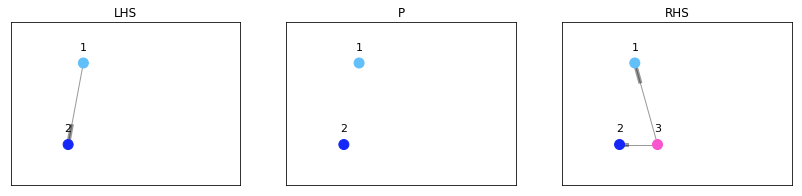

In [16]:
lhs = nx.DiGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(1, 2)])

p = nx.DiGraph()
p.add_nodes_from([1, 2])
p.add_edges_from([])

rhs = nx.DiGraph()
rhs.add_nodes_from([1, 2, 3])
rhs.add_edges_from([(3, 1), (3, 2)])

# By default if `p_lhs` and `p_rhs` are not provided
# to a rule, it tries to construct this homomorphisms
# automatically by matching the names. In this case we
# have defined lhs, p and rhs in such a way that that
# the names of the matching nodes correspond
rule = Rule(p, lhs, rhs)
plot_rule(rule)

Now, we would like to use the rule defined above in the following context: in the graph `G_prime` we want to find _"protien"_ nodes connected to _"binding"_ nodes and to delete the edge connecting them, after that we would like to add a new intermediary node and connect it to the previous _"protein"_ and _"binding"_.

We can provide this context by specifying a typing of the $LHS$ of the rule, which would indicated that node `1` is a _"protein"_, and node `2` is a _"binding"_. Now the hierarchy will search for a matching of $LHS$ respecting the types of the nodes.

In [17]:
lhs_typing = {
    "G": {
        1: "protein",
        2: "binding"
    }
}

`regraph.library.Hierarchy` provides the method `find_matching` to find matchings of a pattern in a given graph in the hierarchy. The typing of $LHS$ should be provided to the `find_matching` method.

Instances found without pattern typing:
{1: 'SH2', 2: 'Grb2'}


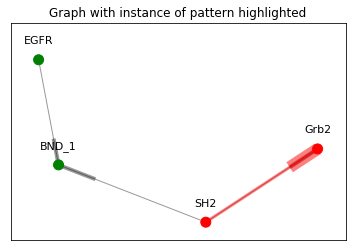

{1: 'SH2', 2: 'BND_1'}


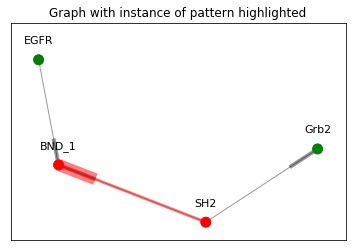

{1: 'EGFR', 2: 'BND_1'}


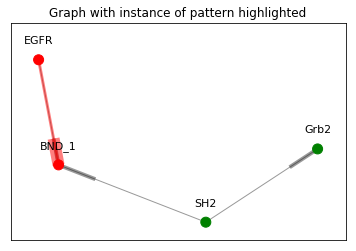



Instances found with pattern typing:
{1: 'EGFR', 2: 'BND_1'}


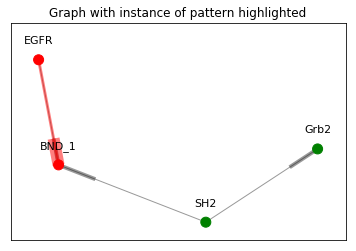

In [18]:
# Find matching of lhs without lhs_typing
instances_untyped = simple_hierarchy.find_matching("G_prime", lhs)
print("Instances found without pattern typing:")
for instance in instances_untyped:
    print(instance)
    plot_instance(simple_hierarchy.node["G_prime"].graph, lhs, instance, pos=pos)

# Find matching of lhs with lhs_typing
instances = simple_hierarchy.find_matching("G_prime", lhs, lhs_typing)
print("\n\nInstances found with pattern typing:")
for instance in instances:
    print(instance)
    plot_instance(simple_hierarchy.node["G_prime"].graph, lhs, instance, pos=pos)

As a rewriting rule can implement addition and merging of some nodes, an appropriate typing of the $RHS$ allows to specify the typing for new/merged nodes.

- By default, if a typing of $RHS$ is not provided, all the nodes added and merged will be not typed. **Note:** If a graph $G$ was totally typed by some graph $T$, and a rewriting rule which transforms $G$ into $G'$ has added/merged some nodes for which there is no typing in $T$ specified, $G'$ will become only _partially_ typed by $T$ and ReGraph will raise a warning.

- If a typing of a new node is specified in the $RHS$ typing, the node will have this type as long as it is consistent (homomrophism $G' \rightarrow T$ is valid) with $T$.

- If a typing of a merged node is specified in the $RHS$ typing, the node will have this type as long as (a) all the nodes that were merged had this type or were not typed, (b) new typing is a consistent homomrophism ($G' \rightarrow T$ is valid).

For our example, we will not specify the type of the new node `3`, so that `G_prime` after rewriting will become only parially typed by `G`.

In [19]:
rhs_typing = {
#     "G": {
#         1: "protein",
#         2: "binding",
# #         3: "region"
#     }
}

Now, rewriting can be performed using `regraph.library.hierarchy.Hierarchy.rewrite` method. It takes as an input id of the graph to rewrite, a rule, an instance of the LHS of a rule ($LHS \rightarrow G$), and a typing of $LHS$ and $RHS$.

**Note:** In case the graph to be rewritten is not typed by any other graph in the hierarchy, the $LHS$ and $RHS$ typings are not required.

In [20]:
# try:
#     simple_hierarchy.rewrite("G_prime", instances_untyped[1], rule, lhs_typing, rhs_typing)
# except:
#     print("If typing of the instance of LHS does not coincide with typing of LHS, rewriting procedure returns and error!")

In [21]:
simple_hierarchy.rewrite("G_prime", rule, instances[0], lhs_typing, rhs_typing, total=False)

/home/johnpaul/anaconda3/lib/python3.5/site-packages/ReGraph-0.3-py3.5.egg/regraph/library/hierarchy.py:1409: UserWarning: Total typing 'G_prime->G' became partial after rewriting!
  (s, t)


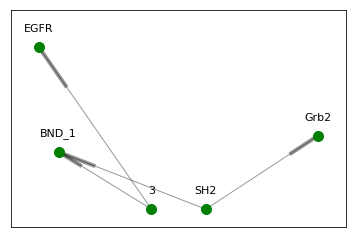

{'SH2': array([ 0.59931081,  0.        ]),
 3: array([ 0.40458072,  0.        ]),
 'EGFR': array([ 0.       ,  0.8646606]),
 'Grb2': array([ 1.        ,  0.38999717]),
 'BND_1': array([ 0.07150671,  0.30506087])}

In [22]:
plot_graph(simple_hierarchy.node["G_prime"].graph, parent_pos=pos)

In [23]:
print("Node types in `G_prime` after rewriting: \n")
for node in simple_hierarchy.node["G_prime"].graph.nodes():
    print(node, simple_hierarchy.node_type("G_prime", node))

Node types in `G_prime` after rewriting: 

SH2 {'G': 'region'}
3 {}
EGFR {'G': 'protein'}
Grb2 {'G': 'protein'}
BND_1 {'G': 'binding'}


Later on if a node form $G$ is not typed in $T$, we can specify a typing for this node.

In the example we type the node `3` as a `region` in `G`.

In [24]:
simple_hierarchy.add_node_type("G_prime", 3,  "G", "region")

It is also possible to remove a graph from the hierarchy using the `regraph.library.hierarchy.Hierarchy.remove_graph` method. It takes as an input the id of a graph to remove, and if the argument `reconnect` is set to `True`, it reconnects all the graphs typed by the graph being removed to the graphs typing it.

In our example if we remove graph `G` from the hierarchy, `G_prime` is now directly typed by `T`.

In [25]:
simple_hierarchy.remove_graph("G", reconnect=True)
print(simple_hierarchy)
print("New node types in 'G_prime':\n")
for node in simple_hierarchy.node["G_prime"].graph.nodes():
    print(node, ": ", simple_hierarchy.node_type("G_prime", node))


Graphs (directed == True): 

Nodes:
Graph: T {'name': 'Agent interaction'}
Graph: G_prime {'name': 'EGFR and Grb2 binding'}

Typing homomorphisms: 
G_prime -> T: total == False, ignore_attrs == False

attributes : 
{}

New node types in 'G_prime':

SH2 :  {'T': 'agent'}
3 :  {'T': 'agent'}
EGFR :  {'T': 'agent'}
Grb2 :  {'T': 'agent'}
BND_1 :  {'T': 'action'}


### 2. Example: advanced hierarchy

The following example illustrates more sophisticaled hierarchy example.

#### 2.1. DAG hierarchy

In [26]:
hierarchy = Hierarchy()

colors = nx.DiGraph()
colors.add_nodes_from([
        "green", "red", "blue"
    ])
colors.add_edges_from([
        ("red", "green"),
        ("red", "red"),
        ("green", "green"),
        ("blue", "red")
    ])
hierarchy.add_graph("colors", colors, {"id": "https://some_url"})

shapes = nx.DiGraph()
shapes.add_nodes_from(["circle", "square"])
shapes.add_edges_from([
        ("circle", "square"),
        ("square", "circle"),
        ("circle", "circle")
    ])
hierarchy.add_graph("shapes", shapes)

quality = nx.DiGraph()
quality.add_nodes_from(["good", "bad"])
quality.add_edges_from([
        ("bad", "bad"),
        ("bad", "good"),
        ("good", "good")
    ])
hierarchy.add_graph("quality", quality)

g1 = nx.DiGraph()
g1.add_nodes_from([
    "red_circle",
    "red_square",
    "green_circle",
    "green_square",
    "some_circle",
])
g1.add_edges_from([
    ("red_circle", "green_circle"),
    ("red_circle", "red_square"),
    ("red_circle", "red_circle"),
    ("red_square", "red_circle"),
    ("green_circle", "green_square"),
    ("green_square", "green_circle"),
    ("some_circle", "red_circle")
])
g1_colors = {
    "red_circle": "red",
    "red_square": "red",
    "green_circle": "green",
    "green_square": "green"
}
g1_shapes = {
    "red_circle": "circle",
    "red_square": "square",
    "green_circle": "circle",
    "green_square": "square",
    "some_circle": "circle"
}

hierarchy.add_graph("g1", g1)
hierarchy.add_typing("g1", "colors", g1_colors, total=False)
hierarchy.add_typing("g1", "shapes", g1_shapes, total=True)

g2 = nx.DiGraph()
g2.add_nodes_from([
    "good_circle",
    "good_square",
    "bad_circle",
    "bad_square",
    "good_guy",
    "bad_guy",
    "some_node"
])
g2.add_edges_from([
    ("good_circle", "good_square"),
    ("good_square", "good_circle"),
    ("bad_circle", "good_circle"),
    ("bad_square", "bad_circle"),
    ("bad_circle", "good_square"),
    ("bad_circle", "bad_circle"),
    ("bad_guy", "good_guy"),
    ("some_node", "good_circle"),
    ("bad_guy", "bad_square")
])
g2_shapes = {
    "good_circle": "circle",
    "good_square": "square",
    "bad_circle": "circle",
    "bad_square": "square"
}
g2_quality = {
    "good_circle": "good",
    "good_square": "good",
    "bad_circle": "bad",
    "bad_square": "bad",
    "bad_guy": "bad",
    "good_guy": "good"
}

hierarchy.add_graph("g2", g2)
hierarchy.add_typing("g2", "shapes", g2_shapes)
hierarchy.add_typing("g2", "quality", g2_quality)

g3 = nx.DiGraph()
g3.add_nodes_from([
    "good_red_circle",
    "bad_red_circle",
    "good_green_square",
    "bad_green_circle",
    "good_red_square",
    "some_circle_node",
    "some_strange_node"
])
g3.add_edges_from([
    ("bad_red_circle", "good_red_circle"),
    ("bad_red_circle", "good_red_square"),
    ("bad_red_circle", "bad_green_circle"),
    ("bad_green_circle", "good_green_square"),
    ("good_red_square", "good_red_circle"),
    ("good_red_circle", "good_red_square")
])

g3_g1 = {
    "good_red_circle": "red_circle",
    "bad_red_circle": "red_circle",
    "good_green_square": "green_square",
    "bad_green_circle": "green_circle",
    "good_red_square": "red_square",
    "some_circle_node": "some_circle"
}

g3_g2 = {
    "good_red_circle": "good_circle",
    "bad_red_circle": "bad_circle",
    "good_green_square": "good_square",
    "bad_green_circle": "bad_circle",
    "good_red_square": "good_square",
    "some_strange_node": "some_node"
}

hierarchy.add_graph("g3", g3)
hierarchy.add_typing("g3", "g1", g3_g1)
hierarchy.add_typing("g3", "g2", g3_g2)

Some of the graphs in the hierarchy are now typed by multiple graphs, which is reflected in the types of nodes, as in the example below:

In [27]:
print("Node types in G3:\n")
for node in hierarchy.node["g3"].graph.nodes():
    print(node, hierarchy.node_type("g3", node))

Node types in G3:

some_strange_node {'g2': 'some_node'}
good_green_square {'g1': 'green_square', 'g2': 'good_square'}
some_circle_node {'g1': 'some_circle'}
bad_green_circle {'g1': 'green_circle', 'g2': 'bad_circle'}
bad_red_circle {'g1': 'red_circle', 'g2': 'bad_circle'}
good_red_square {'g1': 'red_square', 'g2': 'good_square'}
good_red_circle {'g1': 'red_circle', 'g2': 'good_circle'}


Notice that as `G3` is paritally typed by both `G1` and `G2`, not all the nodes have types in both `G1` and `G2`. For example, node `some_circle_node` is typed only by `some_circle` in `G1`, but is not typed by any node in `G2`.

#### 2.2. Rules as nodes of a hierarchy

Having constructed a sophisticated rewriting rule typed by some nodes in the hierarchy one may want to store this rule and to be able to propagate any changes that happen in the hierarchy to the rule as well.  

ReGraph's `regraph.library.hierarchy.Hierarchy` allows to add graph rewriting rules as nodes in the hierarchy. Rules in the hierarchy can be (partially) typed by graphs. 

**Note:** nothing can be typed by a rule in the hierarchy.

In the example below, a rule is added to the previously constructed hierarchy and typed by graphs `g1` and `g2`:

In [28]:
lhs = nx.DiGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(1, 2)])

p = nx.DiGraph()
p.add_nodes_from([1, 11, 2])
p.add_edges_from([(1, 2)])

rhs = copy.deepcopy(p)

p_lhs = {1: 1, 11: 1, 2: 2}
p_rhs = {1: 1, 11: 11, 2: 2}

r1 = Rule(p, lhs, rhs, p_lhs, p_rhs)
hierarchy.add_rule("r1", r1, {"desc": "Rule 1: typed by two graphs"})

lhs_typing1 = {1: "red_circle", 2: "red_square"}
rhs_typing1 = {1: "red_circle", 11: "red_circle", 2: "red_square"}

lhs_typing2 = {1: "good_circle", 2: "good_square"}
rhs_typing2 = {1: "good_circle", 11: "good_circle", 2: "good_square"}

hierarchy.add_rule_typing("r1", "g1", lhs_typing1, rhs_typing1)
hierarchy.add_rule_typing("r1", "g2", lhs_typing2, rhs_typing2)

In [29]:
print(hierarchy)


Graphs (directed == True): 

Nodes:
Graph: quality {}
Graph: g2 {}
Rule: r1 {'desc': 'Rule 1: typed by two graphs'}
Graph: colors {'id': 'https://some_url'}
Graph: g1 {}
Graph: g3 {}
Graph: shapes {}

Typing homomorphisms: 
g2 -> quality: total == False, ignore_attrs == False
g2 -> shapes: total == False, ignore_attrs == False
r1 -> g1: lhs_total == False, rhs_total == False, ignore_attrs == False
r1 -> g2: lhs_total == False, rhs_total == False, ignore_attrs == False
g1 -> colors: total == False, ignore_attrs == False
g1 -> shapes: total == True, ignore_attrs == False
g3 -> g1: total == False, ignore_attrs == False
g3 -> g2: total == False, ignore_attrs == False

attributes : 
{}



#### 2.3. Rewriting and propagation

We now show how graph rewriting can be performed in such an hierarchy. In the previous example we perfromed graph rewriting on the top level of the hierarchy, meaning that the graph that was rewritten did not type any other graph.

The following example illustrates what happens if we rewrite a graph typing some other graphs. The ReGraph hierarchy is able to propagate the changes made by rewriting on any level to all the graphs (as well as the rules) typed by the one subject to rewriting.

In [30]:
lhs = nx.DiGraph()
lhs.add_nodes_from(["a", "b"])
lhs.add_edges_from([
        ("a", "b"),
        ("b", "a")
    ])
p = nx.DiGraph()
p.add_nodes_from(["a", "a1", "b"])
p.add_edges_from([
        ("a", "b"),
        ("a1", "b")
    ])
rhs = copy.deepcopy(p)
rule = Rule(
    p, lhs, rhs,
    {"a": "a", "a1": "a", "b": "b"},
    {"a": "a", "a1": "a1", "b": "b"},
)

Instances:
{'a': 'square', 'b': 'circle'}


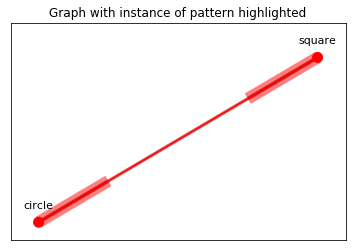

{'a': 'circle', 'b': 'square'}


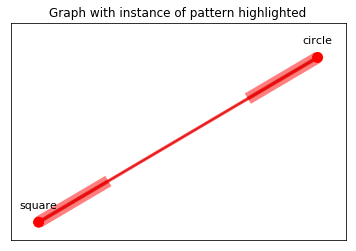

In [31]:
instances = hierarchy.find_matching("shapes", lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(hierarchy.node["shapes"].graph, rule.lhs, instance)

In [32]:
hierarchy.rewrite("shapes", rule, {"a": "circle", "b": "square"})

In [33]:
sep = "========================================\n\n"

print("Graph 'shapes':\n")
print("===============")
print_graph(hierarchy.node["shapes"].graph)
print(sep)

print("Graph 'g1':\n")
print("===========")
print_graph(hierarchy.node["g1"].graph)
print(sep)

print("Graph 'g2':\n")
print("===========")
print_graph(hierarchy.node["g2"].graph)
print(sep)

print("Graph 'g3':\n")
print("===========")
print_graph(hierarchy.node["g3"].graph)
print(sep)

print("Rule 'r1':\n")
print("===========")
print("\nLHS:")
print_graph(hierarchy.node["r1"].rule.lhs)

print("\nP:")
print_graph(hierarchy.node["r1"].rule.p)

print("\nRHS:")
print_graph(hierarchy.node["r1"].rule.rhs)

Graph 'shapes':


Nodes:

circle1  :  {}
square  :  {}
circle  :  {}

Edges:

circle1 -> square  :  {}
circle1 -> circle1  :  {}
circle1 -> circle  :  {}
circle -> square  :  {}
circle -> circle1  :  {}
circle -> circle  :  {}


Graph 'g1':


Nodes:

green_circle1  :  {}
green_circle  :  {}
red_circle  :  {}
green_square  :  {}
some_circle1  :  {}
red_circle1  :  {}
red_square  :  {}
some_circle  :  {}

Edges:

green_circle1 -> green_square  :  {}
green_circle -> green_square  :  {}
red_circle -> red_circle  :  {}
red_circle -> green_circle1  :  {}
red_circle -> green_circle  :  {}
red_circle -> red_square  :  {}
red_circle -> red_circle1  :  {}
some_circle1 -> red_circle  :  {}
some_circle1 -> red_circle1  :  {}
red_circle1 -> red_circle  :  {}
red_circle1 -> green_circle1  :  {}
red_circle1 -> green_circle  :  {}
red_circle1 -> red_square  :  {}
red_circle1 -> red_circle1  :  {}
some_circle -> red_circle  :  {}
some_circle -> red_circle1  :  {}


Graph 'g2':


Nodes:

bad_circle  :  

#### 2.4 Rewriting with the rules in the hierarchy

ReGraph provides utils that allow to apply rules stored in the hierarchy to the graph nodes of the hierarchy.

In the following example the rule `r1` is being applied for rewriting of the graph `g3`. 

In [34]:
instances = hierarchy.find_rule_matching("g3", "r1")
hierarchy.apply_rule(
    "g3",
    "r1",
    instances[0]
)

In [35]:
print_graph(hierarchy.node["g3"].graph)


Nodes:

some_strange_node  :  {}
some_circle_node1  :  {}
some_circle_node  :  {}
good_red_circle1  :  {}
bad_green_circle  :  {}
bad_green_circle1  :  {}
good_red_circle  :  {}
good_green_square  :  {}
good_red_circle2  :  {}
bad_red_circle  :  {}
good_red_square  :  {}
bad_red_circle1  :  {}
good_red_circle11  :  {}

Edges:

good_red_circle1 -> good_red_square  :  {}
bad_green_circle -> good_green_square  :  {}
bad_green_circle1 -> good_green_square  :  {}
good_red_circle2 -> good_red_square  :  {}
bad_red_circle -> good_red_circle2  :  {}
bad_red_circle -> good_red_circle1  :  {}
bad_red_circle -> bad_green_circle  :  {}
bad_red_circle -> good_red_circle11  :  {}
bad_red_circle -> good_red_square  :  {}
bad_red_circle -> bad_green_circle1  :  {}
bad_red_circle -> good_red_circle  :  {}
bad_red_circle1 -> good_red_circle2  :  {}
bad_red_circle1 -> good_red_circle1  :  {}
bad_red_circle1 -> bad_green_circle  :  {}
bad_red_circle1 -> good_red_circle11  :  {}
bad_red_circle1 -> good_re

#### 2.5 Export/load hierarchy

ReGraph provides the following methods for loading and exporting your hierarchy:

- `regraph.library.hierarchy.Hierarchy.to_json` creates a json representations of the hierarchy;

- `regraph.library.hierarchy.Hierarchy.from_json` loads an hierarchy from json representation (returns new `Hierarchy` object); 
- `regraph.library.hierarchy.Hierarchy.export` exports the hierarchy to a file (json format);
- `regraph.library.hierarchy.Hierarchy.load` loads an hierarchy from a .json file (returns new object as well).

In [36]:
hierarchy_json = hierarchy.to_json()

In [37]:
new_hierarchy = Hierarchy.from_json(hierarchy_json, directed=True)

In [38]:
new_hierarchy == hierarchy

True

### 3. Example: advanced rule and rewriting

By default rewriting requires all the nodes in the result of the rewriting to be totally typed by all the graphs typing the graph subject to rewriting. If parameter `total` in the rewriting is set to `False`, rewriting is allowed to produce untyped nodes.

In addition, rewriting is available in these possible configurations:

1. **Strong typing of a rule** (default) autocompletes the types of the nodes in a rule with the respective types of the matching.

2. **Weak typing of a rule:** (parameter `strong=False`) only checks the consistency of the types given explicitly by a rule, and allows to remove node types. If typing of a node in RHS does not contain explicit typing by some typing graph -- this node will be not typed by this graph in the result.

**Note: ** Weak typing should be used with parameter `total` set to False, otherwise deletion of node types will be not possible.


Examples below illustrate some interesting use-cases of rewriting with different rule examples.

In [39]:
base = nx.DiGraph()
base.add_nodes_from([
        ("circle", {"a": {1, 2}, "b": {3, 4}}),
        ("square", {"a": {3, 4}, "b": {1, 2}})
    ])
base.add_edges_from([
        ("circle", "circle", {"c": {1, 2}}),
        ("circle", "square", {"d": {1, 2}}),
    ])

little_hierarchy = Hierarchy()
little_hierarchy.add_graph("base", base)

graph = nx.DiGraph()
graph.add_nodes_from([
        ("c1", {"a": {1}}),
        ("c2", {"a": {2}}),
        "s1",
        "s2",
        ("n1", {"x":{1}})
    ])
graph.add_edges_from([
        ("c1", "c2", {"c": {1}}),
        ("c2", "s1"),
        ("n1", "s2", {"y": {1}})
    ])

little_hierarchy.add_graph("graph", graph)
little_hierarchy.add_typing(
    "graph", "base",
    {
        "c1": "circle",
        "c2": "circle",
        "s1": "square",
        "s2": "square"
    }
)

#### 3.1. Strong typing of a rule

Main idea of strong typing is that the typing of LHS and RHS can be inferred from the matching and autocompleted respectively. It does not allow deletion of types as every node preserved throughout the rewriting will keep its original type.

In [48]:
# In this rule we match any pair of nodes and try to add an edge between them
# the rewriting will fail every time the edge is not allowed between two nodes
# by its typing graphs
current_hierarchy = copy.deepcopy(little_hierarchy)

# define a rule
lhs = nx.DiGraph()
lhs.add_nodes_from([1, 2])

p = copy.deepcopy(lhs)
rhs = copy.deepcopy(lhs)
rhs.add_edges_from([(1, 2)])

rule = Rule(p, lhs, rhs)

instances = current_hierarchy.find_matching(
    "graph",
    rule.lhs
)
for instance in instances:
    try:
        current_hierarchy.rewrite(
            "graph",
            rule,
            instance
        )
    except ValueError as e:
        print("\nFailed to rewrite an instance: ", instance)
        print("Addition of an edge was not allowed, error message received:")
        print(e)
        print()

print_graph(current_hierarchy.node["graph"].graph)

print("\n\nTypes of nodes after rewriting:")
for node in current_hierarchy.node["graph"].graph.nodes():
    print(node, current_hierarchy.node_type("graph", node))


Failed to rewrite an instance:  {1: 's1', 2: 'c2'}
Addition of an edge was not allowed, error message received:
Invalid homomorphism: Connectivity is not preserved! Was expecting an edge between 'square' and 'circle'


Failed to rewrite an instance:  {1: 's2', 2: 'c2'}
Addition of an edge was not allowed, error message received:
Invalid homomorphism: Connectivity is not preserved! Was expecting an edge between 'square' and 'circle'


Failed to rewrite an instance:  {1: 's1', 2: 's2'}
Addition of an edge was not allowed, error message received:
Invalid homomorphism: Connectivity is not preserved! Was expecting an edge between 'square' and 'square'


Failed to rewrite an instance:  {1: 's2', 2: 's1'}
Addition of an edge was not allowed, error message received:
Invalid homomorphism: Connectivity is not preserved! Was expecting an edge between 'square' and 'square'


Failed to rewrite an instance:  {1: 's1', 2: 'c1'}
Addition of an edge was not allowed, error message received:
Invalid hom

#### 3.2. Strong + total typing of a rule

#### 3.3. Weak typing of a rule

If rewriting parameter `strong_typing` is set to `False`, the weak typing of a rule is applied. All the types of the nodes in the RHS of the rule which do not have explicitly specified types will be removed. 

In [41]:
current_hierarchy = copy.deepcopy(little_hierarchy)

# define a rule
lhs = nx.DiGraph()
lhs.add_nodes_from([1, 2])
lhs.add_edges_from([(2, 1)])

p = nx.DiGraph()
p.add_nodes_from([1, 2, 3])
p.add_edges_from([
        (2, 1),
        (3, 1)
    ])

rhs = copy.deepcopy(p)

p_lhs = {1: 1, 2: 2, 3: 2}

rule_1 = Rule(p, lhs, rhs, p_lhs)

# define rule typing

lhs_typing = {
    "base": {
        1: "square"
    }
}

instances = current_hierarchy.find_matching(
    "graph",
    rule_1.lhs,
    lhs_typing
)

print("Rewriting instance: %s" % {1: "s1", 2: "c2"})
current_hierarchy.rewrite(
    "graph",
    rule_1,
    {1: "s1", 2: "c2"},
    lhs_typing,
    strong_typing=False,
    total=False
)
print_graph(current_hierarchy.node["graph"].graph)

print("\n\nTypes of nodes after rewriting:")
for node in current_hierarchy.node["graph"].graph.nodes():
    print(node, current_hierarchy.node_type("graph", node))

Rewriting instance: {1: 's1', 2: 'c2'}

Nodes:

c2  :  {'a': {2}}
s2  :  {}
c1  :  {'a': {1}}
n1  :  {'x': {1}}
s1  :  {}
c21  :  {'a': {2}}

Edges:

c2 -> s1  :  {}
c1 -> c2  :  {'c': {1}}
c1 -> c21  :  {'c': {1}}
n1 -> s2  :  {'y': {1}}
c21 -> s1  :  {}


Types of nodes after rewriting:
c2 {}
s2 {'base': 'square'}
c1 {'base': 'circle'}
n1 {}
s1 {}
c21 {}


In [42]:
current_hierarchy = copy.deepcopy(little_hierarchy)

rhs_typing = {
    "base": {
        1: "square",
        2: "circle"
    }
}

print("Rewriting instance: %s" % {1: "s1", 2: "c2"})
current_hierarchy.rewrite(
    "graph",
    rule_1,
    {1: "s1", 2: "c2"},
    lhs_typing,
    rhs_typing,
    strong_typing=False,
    total=False
)
print_graph(current_hierarchy.node["graph"].graph)

print("\n\nTypes of nodes after rewriting:")
for node in current_hierarchy.node["graph"].graph.nodes():
    print(node, current_hierarchy.node_type("graph", node))

Rewriting instance: {1: 's1', 2: 'c2'}
circle
circle

Nodes:

c2  :  {'a': {2}}
s2  :  {}
c1  :  {'a': {1}}
n1  :  {'x': {1}}
s1  :  {}
c21  :  {'a': {2}}

Edges:

c2 -> s1  :  {}
c1 -> c2  :  {'c': {1}}
c1 -> c21  :  {'c': {1}}
n1 -> s2  :  {'y': {1}}
c21 -> s1  :  {}


Types of nodes after rewriting:
c2 {'base': 'circle'}
s2 {'base': 'square'}
c1 {'base': 'circle'}
n1 {}
s1 {'base': 'square'}
c21 {}


Using rewriting with weak typing it is possible to merge nodes of different types and as long as new node (the result of merging) is untyped.

In [43]:
current_hierarchy = copy.deepcopy(little_hierarchy)


# define a rule
lhs2 = nx.DiGraph()
lhs2.add_nodes_from([1, 2, 3, 4])
lhs2.add_edges_from([(2, 1), (4, 3)])

p2 = copy.deepcopy(lhs2)

rhs2 = nx.DiGraph()
rhs2.add_nodes_from([1, 2, 3])
rhs2.add_edges_from([(2, 1), (2, 3)])

p_rhs2 = {1: 1, 2: 2, 3: 3, 4: 2}

rule_2 = Rule(p2, lhs2, rhs2, p_rhs=p_rhs2)

# define rule typing

lhs_typing = {
    "base": {
        1: "square", 
        3: "square"
    }
}

instances = current_hierarchy.find_matching(
    "graph",
    rule_2.lhs,
    lhs_typing,
)

print("Rewriting instance: %s" % instances[0])
current_hierarchy.rewrite(
    "graph",
    rule_2,
    instances[0],
    lhs_typing,
    lhs_typing,
    strong_typing=False,
    total=False
)
print_graph(current_hierarchy.node["graph"].graph)

print("\n\nTypes of nodes after rewriting:")
for node in current_hierarchy.node["graph"].graph.nodes():
    print(node, current_hierarchy.node_type("graph", node))

Rewriting instance: {1: 's1', 2: 'c2', 3: 's2', 4: 'n1'}

Nodes:

s1  :  {}
s2  :  {}
c2_n1  :  {'a': {2}, 'x': {1}}
c1  :  {'a': {1}}

Edges:

c2_n1 -> s1  :  {}
c2_n1 -> s2  :  {'y': {1}}
c1 -> c2_n1  :  {'c': {1}}


Types of nodes after rewriting:
s1 {'base': 'square'}
s2 {'base': 'square'}
c2_n1 {}
c1 {'base': 'circle'}
